# Fake News detection with tensorflow and nltk using LSTMs

In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score, recall_score,
    roc_curve, roc_auc_score, RocCurveDisplay
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm


plt.style.use("ggplot")

# Base LSTM+ multimodal model

## Load data with features

In [3]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip && unzip -o -d data train-checkpoint3.zip

--2023-04-16 21:15:34--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip [following]
--2023-04-16 21:15:34--  https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85963394 (82M) [application/zip]
Saving to: ‘train-checkpoint3.zip’

train-checkpoint3.z 100%[===================>]  81.98M   208MB/s    in 0.4s    

2023-04-16 21:1

In [2]:
df = pd.read_csv("/kaggle/working/data/train-checkpoint3.csv", index_col=False)

In [3]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
df.head()

,text,text_norm,gulpease_index,smog_index,mean_word_len,real
0,isis leader ‘hiding in mosul’ as troops storm ...,"['isi', 'leader', 'hiding', 'mosul', 'troop', ...",51.2,12.9,5.808260,0.0
1,former speaker john boehner goes low…calls two...,"['former', 'speaker', 'john', 'boehner', 'go',...",62.3,9.9,5.899160,0.0
2,mh370 search: debris found in reunion may give...,"['mh370', 'search', 'debris', 'found', 'reunio...",51.0,13.1,6.231598,1.0
3,a leading us senator: us supporting war in sy...,"['leading', 'u', 'senator', 'u', 'supporting',...",48.0,15.2,6.139583,0.0
4,energy update – collective gridwork fluctuatio...,"['energy', 'update', 'collective', 'gridwork',...",55.8,12.3,6.546789,0.0


In [5]:
df = df.loc[:, df.columns != "text"] # Remove standalone text column

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != "real"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [7]:
X_train

,text_norm,gulpease_index,smog_index,mean_word_len
32162,"['watch', 'news', 'camera', 'catch', 'drug', '...",45.1,0.0,5.555556
14001,"['state', 'department', 'say', 'find', 'email'...",49.6,12.9,6.414573
35625,"['trump', 'visit', 'asia', 'november', 'north'...",50.5,13.8,6.373434
37911,"['colombia', 'farc', 'leader', 'timochenko', '...",48.4,14.0,6.372624
36360,"['trump', 'torture', 'session', 'every', 'day'...",54.7,11.1,5.973684
...,...,...,...,...
6265,"['breaking', 'hispanic', 'men', 'coward', 'bea...",53.0,10.5,5.571429
11284,"['democratic', 'hopeful', 'sander', 'clinton',...",51.5,13.3,6.394256
38158,"['france', 'say', 'saudi', 'coalition', 'must'...",48.5,12.5,6.228070
860,"['palestinian', 'call', 'emergency', 'meeting'...",57.5,13.7,6.363636


In [8]:
X_train.describe()

,gulpease_index,smog_index,mean_word_len
count,34042.000000,34042.000000,34042.000000
mean,52.411480,11.969294,6.101352
std,5.576825,3.484700,0.396024
min,-47.900000,0.000000,3.649660
25%,49.000000,11.200000,5.877928
50%,52.000000,12.500000,6.121951
75%,55.400000,13.800000,6.352941
max,115.000000,28.600000,9.333333


In [9]:
X_train.dtypes

text_norm          object
gulpease_index    float64
smog_index        float64
mean_word_len     float64
dtype: object

In [10]:
y_train.describe()

count    34042.000000
mean         0.439134
std          0.496289
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: real, dtype: float64

Data looks good to create a model

## Final data processing (before model)

I expect a pandas DF that has the columns
- text_norm - Array of splitted and lemmatized words (English only)
- gulpease_index - ...
- smog_index - ...
- mean_word_len - Mean of lengths of words in the text_norm array

In [11]:
MAX_VOCAB = 20000
MAX_LEN = 256

In [12]:
class ModelInputCreator(BaseEstimator, TransformerMixin):
    def __init__(self, max_vocab: int, max_len: int, texts_column: str, numerical_columns: List[str]):
        self.max_vocab = max_vocab
        self.max_len = max_len
        self.texts_column = texts_column
        self.numerical_columns = numerical_columns
        self.scaler = StandardScaler()
        self.tokenizer = Tokenizer(num_words=MAX_VOCAB)
        
    def fit(self, df: pd.DataFrame):
        df = df.reset_index(drop=True)
        self.tokenizer.fit_on_texts(df[self.texts_column])
        self.scaler.fit(df[self.numerical_columns])
        return self
    
    def transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        text_sequences = self.tokenizer.texts_to_sequences(df[self.texts_column])
        text_sequences = pad_sequences(text_sequences, padding="post", maxlen=MAX_LEN)
        numerical = self.scaler.transform(df[self.numerical_columns])
        return (text_sequences, numerical)
    
    def fit_transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        self.fit(df)
        return self.transform(df)

In [13]:
input_creator = ModelInputCreator(
    max_vocab = MAX_VOCAB,
    max_len = MAX_LEN,
    texts_column = "text_norm",
    numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
)

In [14]:
X_train_transformed = input_creator.fit_transform(X_train)

In [15]:
X_train_transformed

(array([[ 270,   36, 1742, ...,    0,    0,    0],
        [ 815,   97,  989, ...,  285, 2645,   80],
        [ 163,    4,  312, ...,  602,   42,    2],
        ...,
        [ 890,   16,  418, ...,    0,    0,    0],
        [ 939,  142, 1354, ...,    0,    0,    0],
        [ 603, 1808,   16, ...,    0,    0,    0]], dtype=int32),
 array([[-1.31106621, -3.4348642 , -1.37820918],
        [-0.50414367,  0.26708755,  0.79092515],
        [-0.34275916,  0.52536325,  0.68704293],
        ...,
        [-0.7013914 ,  0.15229835,  0.31998076],
        [ 0.91245367,  0.49666595,  0.66230363],
        [-0.89863913,  0.61145515,  0.45234232]]))

# RNN Model

## Model building

In [16]:
text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
text_features = tf.keras.layers.Embedding(MAX_VOCAB, 128)(text_input)

text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)

num_input = tf.keras.Input(shape=(3,), name="num_input")
num_features = tf.keras.layers.Dense(32, activation='relu')(num_input)

merged = tf.keras.layers.concatenate([text_features, num_features])
merged = tf.keras.layers.Dense(8)(merged)
merged = tf.keras.layers.Dropout(0.5)(merged)
output = tf.keras.layers.Dense(1)(merged)

model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 256, 128)     2560000     ['text_input[0][0]']             
                                                                                                  
 bidirectional (Bidirectional)  (None, 256, 128)     98816       ['embedding[0][0]']              
                                                                                                  
 num_input (InputLayer)         [(None, 3)]          0           []                               
                                                                                              

## Model fitting

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1022/1022 [==============================] - 149s 132ms/step - loss: 0.3486 - accuracy: 0.8367 - val_loss: 0.1888 - val_accuracy: 0.9280
Epoch 2/10
1022/1022 [==============================] - 57s 56ms/step - loss: 0.1515 - accuracy: 0.9520 - val_loss: 0.1391 - val_accuracy: 0.9471
Epoch 3/10
1022/1022 [==============================] - 47s 46ms/step - loss: 0.0945 - accuracy: 0.9710 - val_loss: 0.1417 - val_accuracy: 0.9477
Epoch 4/10
1022/1022 [==============================] - 47s 46ms/step - loss: 0.0692 - accuracy: 0.9792 - val_loss: 0.1496 - val_accuracy: 0.9504


Sometimes you have to run model building and fitting a couple of times to get desired accuracy.

Best Epoch: Epoch 4/10

1022/1022 [==============================] - 42s 41ms/step - loss: 0.0843 - accuracy: 0.9766 - val_loss: 0.1359 - val_accuracy: 0.9551

## Training Visualization

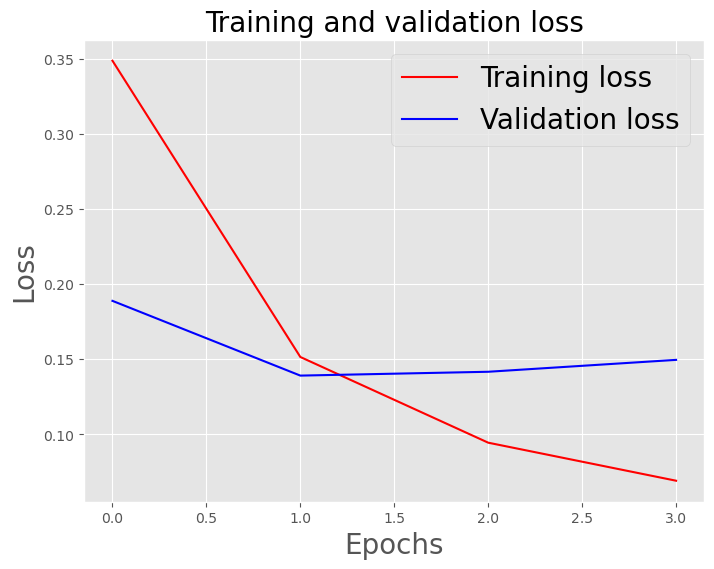

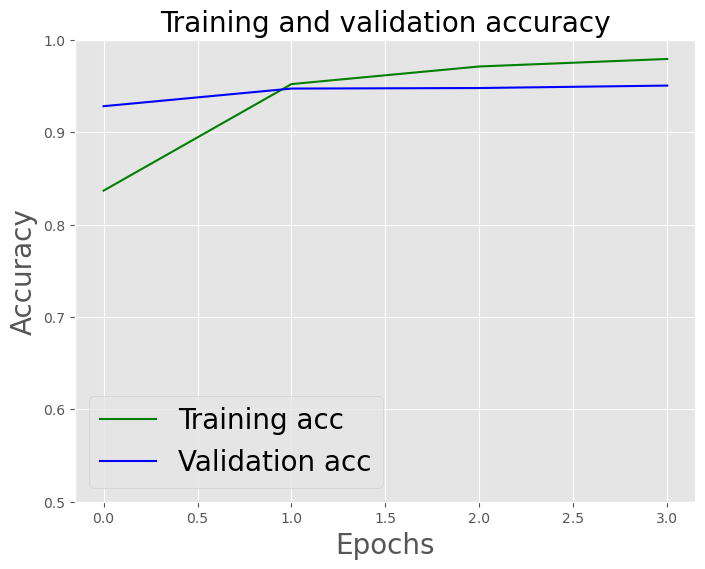

In [18]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Testing

Evaluation of the testing set:

In [19]:
X_test_transformed = input_creator.transform(X_test)

In [20]:
model.evaluate(X_test_transformed, y_test)

266/266 [==============================] - 4s 14ms/step - loss: 0.1355 - accuracy: 0.9490


[0.13552315533161163, 0.9490071535110474]

In [21]:
y_pred = model.predict(X_test_transformed)
roc05 = (y_pred > 0.5) * 1

266/266 [==============================] - 5s 15ms/step


### Confusion Matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

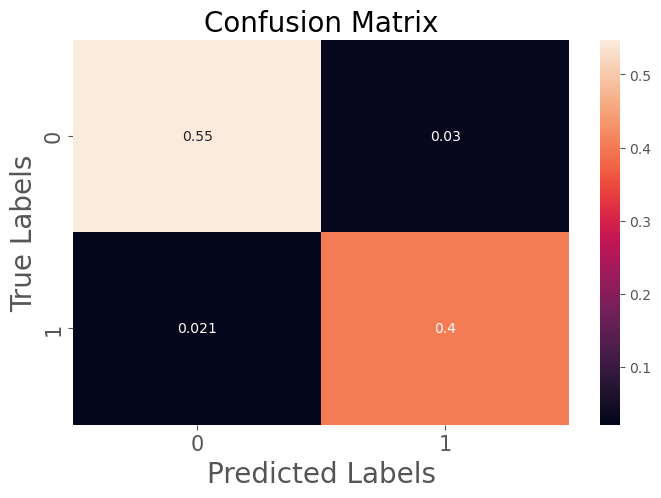

In [22]:
matrix = confusion_matrix(roc05, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [23]:
print(classification_report(y_test, roc05))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96      4838
         1.0       0.95      0.93      0.94      3673

    accuracy                           0.95      8511
   macro avg       0.95      0.95      0.95      8511
weighted avg       0.95      0.95      0.95      8511



### Prepare a array of all roc curves and (auc, gini) scores

In [24]:
roc_curves = []
auc_gini = []

### ROC Curve

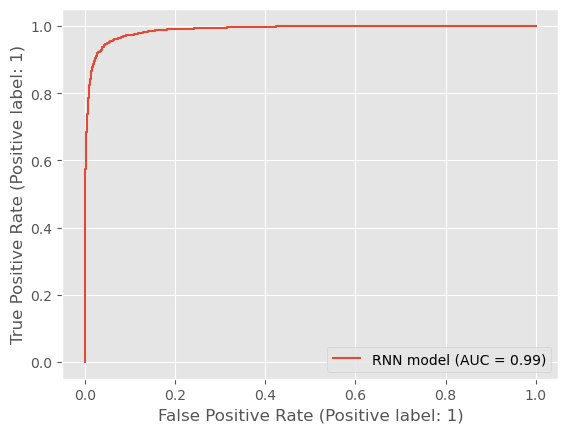

In [25]:
lstm_roc_curve = RocCurveDisplay.from_predictions(y_test, y_pred, name="RNN model")
roc_curves.append(lstm_roc_curve)

### AUC ROC and GINI

In [26]:
auc = roc_auc_score(y_test, y_pred)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.9885289083709409
GINI Score: 0.9770578167418817


In [27]:
auc_gini.append(("RNN Model", auc, gini))

# Other models

With other models we will be using the concatenated matrix of tokenized words and text statistics

In [28]:
X_train_matrix = np.concatenate(X_train_transformed, axis=1)
X_test_matrix =  np.concatenate(X_test_transformed, axis=1)

## XGBoost model

In [29]:
# Train an XGBoost model on the training data, and get predictions for the test data
xgb_model = xgb.XGBClassifier(
    max_depth = 10,
    learning_rate = 0.03,
    objectives = "binary:logistic",
    verbosity=1
)
xgb_model.fit(X_train_matrix, y_train)

[22:29:15] WARNING: ../src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objectives='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [30]:
xgb_preds = xgb_model.predict(X_test_matrix)
xgb_preds

array([1, 0, 1, ..., 1, 0, 0])

In [31]:
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.87      4838
         1.0       0.86      0.76      0.81      3673

    accuracy                           0.84      8511
   macro avg       0.85      0.83      0.84      8511
weighted avg       0.84      0.84      0.84      8511



### ROC Curve

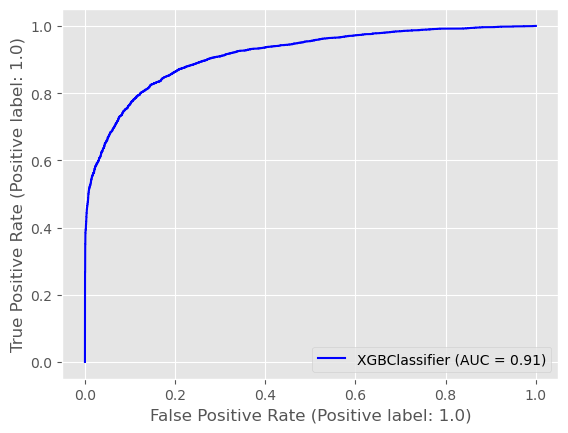

In [32]:
xgb_roc_curve = RocCurveDisplay.from_estimator(xgb_model, X_test_matrix, y_test, name="XGBClassifier", color="blue")
roc_curves.append(xgb_roc_curve)

### AUC ROC and GINI

In [33]:
auc = roc_auc_score(y_test, xgb_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.832258223900609
GINI Score: 0.664516447801218


In [34]:
auc_gini.append(("XGBClassifier", auc, gini))

## Logistic Regression

In [101]:
lr_model = LogisticRegression()

lr_model.fit(X_train_matrix, y_train)

LogisticRegression()

In [102]:
lr_preds = lr_model.predict(X_test_matrix)
lr_preds

array([1., 0., 0., ..., 1., 0., 1.])

In [103]:
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.78      0.71      4838
         1.0       0.61      0.45      0.52      3673

    accuracy                           0.64      8511
   macro avg       0.63      0.62      0.62      8511
weighted avg       0.64      0.64      0.63      8511



### ROC Curve

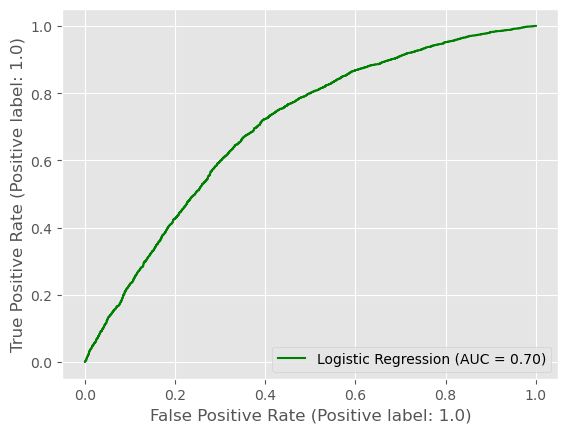

In [104]:
logistic_roc_curve = RocCurveDisplay.from_estimator(lr_model, X_test_matrix, y_test, name="Logistic Regression", color="green")
roc_curves.append(logistic_roc_curve)

### AUC ROC and GINI

In [39]:
auc = roc_auc_score(y_test, lr_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.6189270451380514
GINI Score: 0.23785409027610283


In [40]:
auc_gini.append(("Logistic Regression", auc, gini))

## Random Forest

In [41]:
rf_model = RandomForestClassifier(
    max_depth=15,
    random_state=0,
)

rf_model.fit(X_train_matrix, y_train)

RandomForestClassifier(max_depth=15, random_state=0)

In [42]:
rf_preds = rf_model.predict(X_test_matrix)
rf_preds

array([0., 0., 1., ..., 0., 0., 0.])

In [43]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82      4838
         1.0       0.79      0.68      0.73      3673

    accuracy                           0.78      8511
   macro avg       0.78      0.77      0.77      8511
weighted avg       0.78      0.78      0.78      8511



### ROC Curve

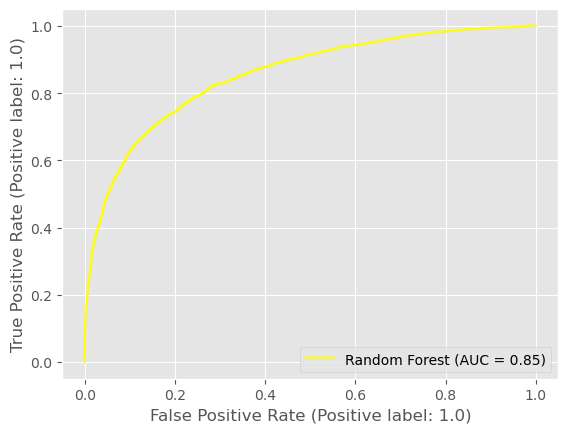

In [44]:
rf_roc_curve = RocCurveDisplay.from_estimator(rf_model, X_test_matrix, y_test, name="Random Forest", color="yellow")
roc_curves.append(rf_roc_curve)

### AUC ROC and GINI

In [45]:
auc = roc_auc_score(y_test, rf_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.7706138455801905
GINI Score: 0.541227691160381


In [46]:
auc_gini.append(("Random Forest", auc, gini))

## SVM - SVC

In [84]:
svc_scaler = StandardScaler()

In [86]:
X_train_svc = svc_scaler.fit_transform(X_train_matrix, y_train)
X_test_svc = svc_scaler.transform(X_test_matrix)

In [87]:
svc_model = SVC(random_state=0, max_iter=1000)

In [88]:
svc_model.fit(X_train_svc, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(max_iter=1000, random_state=0)

In [89]:
svc_preds = svc_model.predict(X_test_svc)
svc_preds

array([0., 0., 0., ..., 1., 1., 1.])

In [90]:
print(classification_report(y_test, svc_preds))

              precision    recall  f1-score   support

         0.0       0.60      0.73      0.66      4838
         1.0       0.50      0.36      0.42      3673

    accuracy                           0.57      8511
   macro avg       0.55      0.54      0.54      8511
weighted avg       0.56      0.57      0.55      8511



### ROC Curve

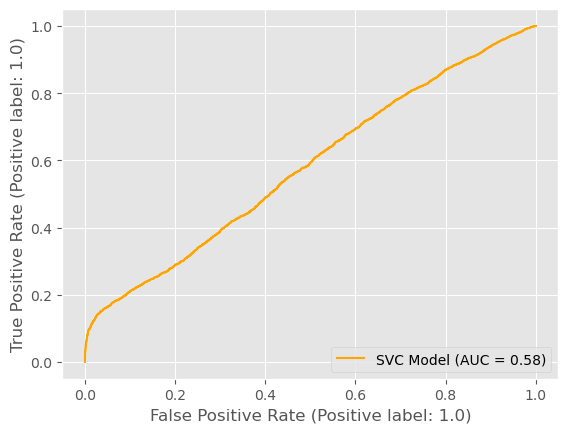

In [124]:
svc_roc_curve = RocCurveDisplay.from_estimator(svc_model, X_test_svc, y_test, name="SVC Model", color="orange")
roc_curves.append(svc_roc_curve)

### AUC ROC and GINI

In [122]:
auc = roc_auc_score(y_test, svc_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.5437686065269426
GINI Score: 0.08753721305388518


In [123]:
auc_gini.append(("SVC", auc, gini))

# Naive Bayes

In [108]:
nb_model = GaussianNB()

nb_model.fit(X_train_matrix, y_train)

GaussianNB()

In [109]:
nb_preds = nb_model.predict(X_test_matrix)
nb_preds

array([0., 1., 1., ..., 1., 1., 1.])

In [110]:
print(classification_report(y_test, nb_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.53      0.59      4838
         1.0       0.51      0.63      0.56      3673

    accuracy                           0.57      8511
   macro avg       0.58      0.58      0.57      8511
weighted avg       0.59      0.57      0.58      8511



### ROC Curve

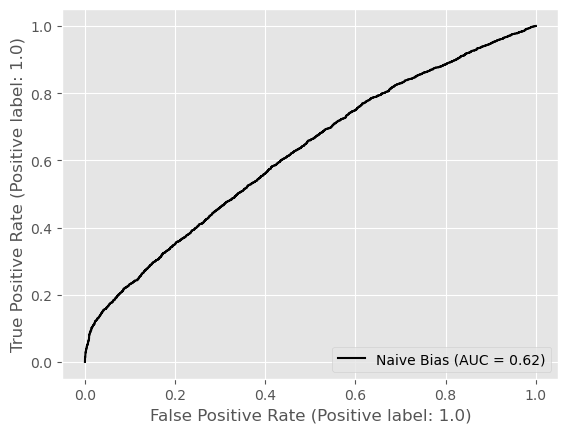

In [111]:
nb_roc_curve = RocCurveDisplay.from_estimator(nb_model, X_test_matrix, y_test, name="Naive Bias", color="black")
roc_curves.append(nb_roc_curve)

### AUC ROC and GINI

In [112]:
auc = roc_auc_score(y_test, nb_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.581105971229896
GINI Score: 0.1622119424597921


In [113]:
auc_gini.append(("Naive Bias", auc, gini))

# Graphing the results of the models

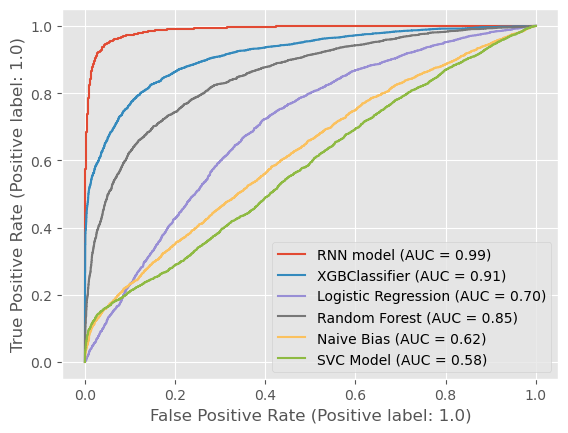

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111)

for curve in roc_curves:
    curve.plot(ax)

In [144]:
res_df = pd.DataFrame(auc_gini)
res_df.columns = ("Model", "AUC", "GINI")
res_df

,Model,AUC,GINI
0,RNN Model,0.988529,0.977058
1,XGBClassifier,0.832258,0.664516
2,Logistic Regression,0.618927,0.237854
3,Random Forest,0.770614,0.541228
4,SVC,0.543769,0.087537
5,Naive Bias,0.581106,0.162212


Text(0, 0.5, 'AUC Score')

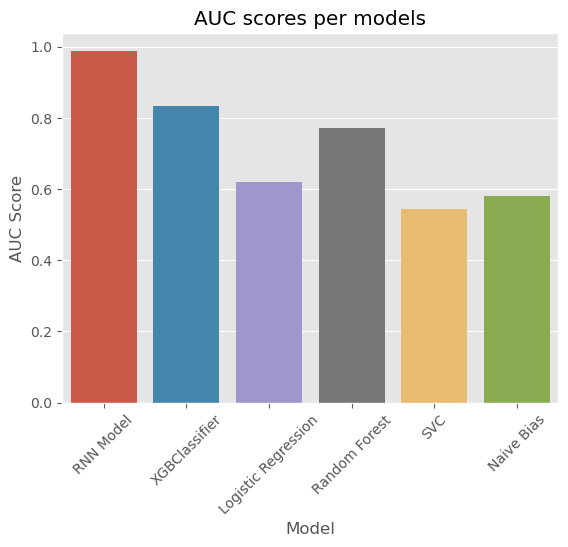

In [157]:
plt.xticks(rotation=45)
plt.title("AUC scores per models")
sns.barplot(res_df, x="Model", y="AUC")
plt.ylabel("AUC Score")

Text(0, 0.5, 'GINI Score')

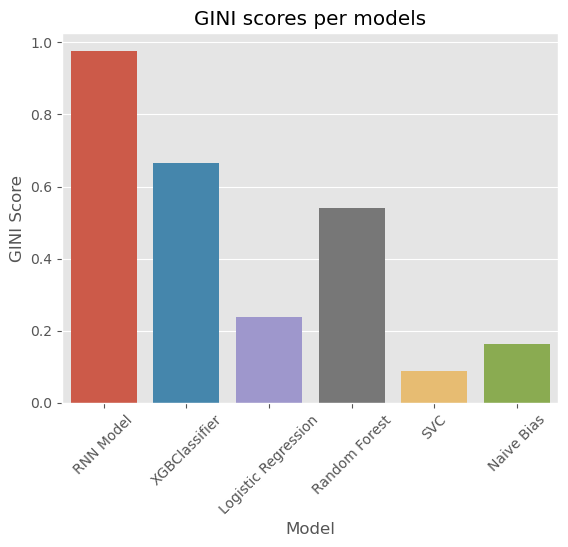

In [156]:
plt.xticks(rotation=45)
plt.title("GINI scores per models")
sns.barplot(res_df, x="Model", y="GINI")
plt.ylabel("GINI Score")

# Combined results (plus stacking)

LR, SVC and Naive Bias models are no suitable to add to stacking

In [114]:
def get_stacking():
    level0 = list()
    level0.append(('xgb', xgb_model))
    level0.append(('rf', rf_model))
    
    level1 = LogisticRegression()
    
    final_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return final_model

In [115]:
def get_models():
    
    models = dict()
    models['xgb'] = xgb.XGBClassifier(
                        max_depth = 10,
                        learning_rate = 0.03,
                        objectives = "binary:logistic",
                        verbosity=1)
    models['rf'] = RandomForestClassifier(max_depth=15, random_state=0)
    models['stacking'] = get_stacking()

    return models

In [118]:
def evaluate_model(model, X, y):
    # k-fold cross-validation
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    return scores

In [119]:
models = get_models()
# Model validation
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_test_matrix, y_test)
    results.append(scores)
    names.append(name)
    print('%8s mean-%.3f std-%.3f' % (name, np.mean(scores), np.std(scores)))

     xgb mean-0.784 std-0.002
      rf mean-0.736 std-0.007
stacking mean-0.787 std-0.004


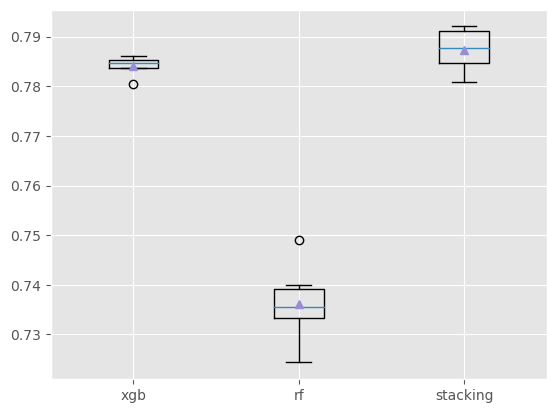

In [159]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## As we can see the best model to tune to best perforance is the RNN model.

This what we are going to do in the last part